# K-Nearest Neighbor (KNN)

Ziel der vorliegenden Aufgabe ist es einen KNN-Kassifikator zu implementieren und auf den Titanic Datensatz anzuwenden. Dabei sollen Sie insbesondere untersuchen welcher Merkmalsraum und welches Ähnlichkeitsmaß für diese Aufgabe geeignet ist. 

Der KNN-Klassifikator ist eine einfache, parameterfreie Methode, bei welcher zu jedem Testvektor $\vec x_q$ die $k$-nächsten-Nachbarn, $\{\vec {x_t^1}...\vec {x_t^k}\}$ im Trainingsbestand, unter Berücksichtigung eines frei zu definierenden Ähnlichkeitsmaß, ermittelt werden. Die Klassenzugehörigkeit wird über einen einfachen Mehrheitsentscheid der nächsten $k$-Nachbarn für $\vec x_q$ prädiziert (siehe auch https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

### Imports

In [1]:
import numpy as np
import csv as csv
import matplotlib.pyplot as plt
import pandas as pd
import itertools
%matplotlib inline

### Daten einlesen

In [2]:
DATA_FILE = './Data/original_titanic.csv'

### Vorbereitungen

Führen Sie hier folgende Bearbeitungsschritte durch:
* (1) Datenlücken interpolieren,
* (2) Datensatz stochastisch verändern, 
* (3) Aufteilung in Trainings- und Testdatensatz.

Sie können Ihre Implementierungen der vorherigen Arbeitsblätter nutzen.

In [3]:
df = pd.read_csv(DATA_FILE, header=0)

def prepareData(df):
    df.loc[(((df.Sex == "male")   &(df.Survived == 0)) & (df.Pclass==1)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "male")   &(df.Survived == 0)) & (df.Pclass==1), "Age"].mean()
    df.loc[(((df.Sex == "male")   &(df.Survived == 0)) & (df.Pclass==2)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "male")   &(df.Survived == 0)) & (df.Pclass==2), "Age"].mean()
    df.loc[(((df.Sex == "male")   &(df.Survived == 0)) & (df.Pclass==3)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "male")   &(df.Survived == 0)) & (df.Pclass==3), "Age"].mean()
    
    df.loc[(((df.Sex == "male")   &(df.Survived == 1)) & (df.Pclass==1)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "male")   &(df.Survived == 1)) & (df.Pclass==1), "Age"].mean()
    df.loc[(((df.Sex == "male")   &(df.Survived == 1)) & (df.Pclass==2)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "male")   &(df.Survived == 1)) & (df.Pclass==2), "Age"].mean()
    df.loc[(((df.Sex == "male")   &(df.Survived == 1)) & (df.Pclass==3)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "male")   &(df.Survived == 1)) & (df.Pclass==3), "Age"].mean()
    
    
    df.loc[(((df.Sex == "female") &(df.Survived == 0)) & (df.Pclass==1)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "female") &(df.Survived == 0)) & (df.Pclass==1), "Age"].mean()
    df.loc[(((df.Sex == "female") &(df.Survived == 0)) & (df.Pclass==2)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "female") &(df.Survived == 0)) & (df.Pclass==2), "Age"].mean()
    df.loc[(((df.Sex == "female") &(df.Survived == 0)) & (df.Pclass==3)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "female") &(df.Survived == 0)) & (df.Pclass==3), "Age"].mean()
    
    df.loc[(((df.Sex == "female") &(df.Survived == 1)) & (df.Pclass==1)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "female") &(df.Survived == 1)) & (df.Pclass==1), "Age"].mean()
    df.loc[(((df.Sex == "female") &(df.Survived == 1)) & (df.Pclass==2)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "female") &(df.Survived == 1)) & (df.Pclass==2), "Age"].mean()
    df.loc[(((df.Sex == "female") &(df.Survived == 1)) & (df.Pclass==3)) & df.Age.isnull(),"Age"] =  df.loc[((df.Sex == "female") &(df.Survived == 1)) & (df.Pclass==3), "Age"].mean()
    return df

print(df.Age.isnull().value_counts())

df = prepareData(df)
df_shuffled = df.sample(frac=1) 
df_train = df_shuffled[:int(len(df_shuffled)* 0.8)] 
df_test  =  df_shuffled[int(len(df_shuffled)* 0.8):] 
print(df.Age.isnull().value_counts())
print("    ")
print(len(df_test))
print(df_test.Age.isnull().value_counts())
print(df.Fare.isnull().value_counts())


False    1046
True      263
Name: Age, dtype: int64
False    1309
Name: Age, dtype: int64
    
262
False    262
Name: Age, dtype: int64
False    1308
True        1
Name: Fare, dtype: int64


### Merkmale standardisieren
Die <i>Standardisierung</i> verleiht den Daten die Eigenschaften einer Standardnormalverteilung. Der Mittelwert jeder Merkmalsspalte beträgt 0, die Standardabweichung jeder Merkmalsspalte beträgt 1. Um zum Beispiel das Merkmal j zu standardiesieren, wird der Mittelwert $\mu$ der jeweiligen Stichprobe abgezogen und das Ergebnis durch die Standardabweichung $\sigma$ dividiert. Das Standardisierungsverfahren wird auf die Merkmalsspalten der Datenmenge einzeln angewendet. Siehe auch: https://en.wikipedia.org/wiki/Standard_score <br>

$x_j^{\prime(i)} = \frac{x_j^{(i)} - \mu_j}{\sigma_j}$. 

Implementieren sie die Funktion <b>normalize()</b> welche die Standardisierung (anhand Mittelwert und Standardabweichung) des Trainingsdatensatzes durchführt. Die Methoden-Parameter können Sie entsprechend Ihrer Implementierung erweitern. Überlegen Sie sich hierbei, welche Merkmale zur Standardisierung geeignet sind und welche nicht. Sie können Ihre Implementierung testen, indem Sie die Werte Mittelwert und Standardabweichung Ihrer standardisierten Merkmalsspalten prüfen. Der Mittelwert sollte 0 sein, die Standardabweichung 1. Geben Sie die Wertre aus.

Speichern Sie sich hierbei die Werte für Mittelwert und Standardabweichung des Trainingsdatensatzes in einer geeigneten Datenstruktur. Führen sie die Standardisierung des Testdatensatzes anhand der Werte von Mittelwert und Standardabweichung vom Trainingsdatensatzes durch. <br>

<b>Wichtiger Hinweis</b>: Implementieren Sie die Funktion eigenständig, eine Standard-Funktion aus einem Framework ist nicht zulässig, wie bspw. *sklearn.preprocessing.StandardScaler*. Zum Testen Ihrer Implementierung können Sie diese Funktion nutzen. Standard-Funktion zur Berechnung von *Mittelwert* und *Standardabweichung* sind selbstverständlich zugelassen. 

In [4]:
def normalize_colummn(feature):
    mean = feature.mean()
    std = feature.std()
    feature_array = feature.to_numpy()
    
    for index in range(len(feature_array)):
        feature_array[index] = (float(feature_array[index]) - mean) / std
        #print(float(feature_array[index]) - mean, feature_array[index])
    return pd.DataFrame(feature_array)

    
def normalize(df):
    new_dataFrame = df.copy()
    new_dataFrame.assign(Age=normalize_colummn(new_dataFrame.Age))
    new_dataFrame.assign(Fare=normalize_colummn(new_dataFrame.Fare))
    return  new_dataFrame # TODO implement

df_train_norm = normalize(df_train) # TODO : implement
df_test_norm =  normalize(df_test) # TODO : implement
print(df_train_norm.describe())
print(df_test_norm.describe())





       PassengerId     Survived       Pclass           Age        SibSp  \
count  1047.000000  1047.000000  1047.000000  1.047000e+03  1047.000000   
mean    651.955110     0.388730     2.288443 -4.496032e-17     0.481375   
std     375.378148     0.487695     0.837054  1.000000e+00     1.008277   
min       1.000000     0.000000     1.000000 -2.202173e+00     0.000000   
25%     326.500000     0.000000     2.000000 -5.638108e-01     0.000000   
50%     651.000000     0.000000     3.000000 -2.126034e-01     0.000000   
75%     976.500000     1.000000     3.000000  5.431909e-01     1.000000   
max    1309.000000     1.000000     3.000000  3.789145e+00     8.000000   

             Parch          Fare  
count  1047.000000  1.046000e+03  
mean      0.366762  1.553888e-16  
std       0.819903  1.000000e+00  
min       0.000000 -6.744511e-01  
25%       0.000000 -5.073848e-01  
50%       0.000000 -3.686163e-01  
75%       0.000000 -1.852555e-02  
max       9.000000  1.016587e+01  
       Pa

### Merkmalsraum definieren
Unabhängig von der eingesetzten Methodik zur Klassifikation ist es wichtig, dass Sie sich Gedanken über den Merkmalsraum machen. Konkret bedeutet das, dass sie definieren müssen wie ein Merkmalsvektor aussieht und mit welchem Ähnlichkeitsmaß Merkmalsvektoren verglichen werden. Sie sollten sich dabei mit den folgenden Fragen auseinander setzen:
* Welche einzelnen Attribute aus einem Objekt des Datensatzes sollen verwendet werden?
* Welche Probleme ergeben sich aufgrund von unterschiedlichen Skalenniveaus der Attribute? Wie können Sie diesen begegnen? 
* Wie gehen Sie mit kategoriellen Merkmalen um?
* Welches Ähnlichkeitsmaß setzen Sie ein? 

### Merkmalsvektor extrahieren und normalisieren bzw. standardisieren
Schreiben sie eine Methode welche aus einer gegebenen Datenreihe einen Merkmalsvektor extrahiert. D.h. der Input ist eine Reihe aus dem Datensatz, der Rückgabewert ein Vektor bestehend aus den Daten.

In [5]:
def extractFeatureVector(row):
    # TODO : implement
    return np.array([row.Fare, row.Age])

Testen Sie die Funktion auf einem beliebigen Objekt des Datensatzes. Überprüfen Sie ob das Resultat Ihren Erwartungen entspricht. 

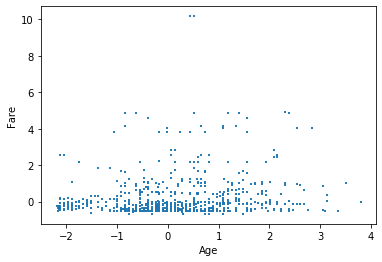

In [6]:
extractFeatureVector(df_train_norm.iloc[0])
points = []
y = []
x = []
for index, row in df_train_norm.iterrows():
    points.append(extractFeatureVector(row))
    y.append(extractFeatureVector(row)[0])
    x.append(extractFeatureVector(row)[1])
data = {'Fare': y, 'Age': x}

new_frame = pd.DataFrame(data)
new_frame.plot.scatter(x = "Age", y = "Fare", marker = ",",s= 1)


Wenn Sie einen nieder-dimensionalen Merkmalsraum, bspw. zwei-dimensional, gewählt haben, lässt sich dieser sehr komfortabel visualisieren. Zum Beispiel:

<img src="./Figures/titanic-nieder-dimensional.png" alt="drawing" style="width:400px;"/>

## Implementierung
Die Implementierung erfolgt innerhalb der Klasse <b>KNN</b>. Im folgenden werden die einzelnen Methoden und deren Funktionsweise kurz vorgestellt. <br>


### Konstruktor
Das KNN-Objekt wird mit dem Wert <b>k</b> initialisiert. Dieser bestimmt die Anzahl der zu betrachtenden Nachbarn. Wählen Sie k=3 als Wert.


### distance()-Methode:
In dieser Methode gilt es eine Funktion zu implementieren, welche die Ähnlichkeit zweier Merkmalsvektoren vergleicht. Diese Methode soll die Ähnlichkeit der zwei Merkmalsvektoren, welche als Methoden-Parameter übergeben werden, bestimmen. Wählen Sie hierbei die aus der Vorlesung bekannten Distanz-Funktionen wie bspw. *Euklidische Distanz*, *Manhatten Distanz*, *Minkovski Distanz* etc. <br>

<b>Auch hier gilt</b>: Implementieren Sie die Funktion eigenständig, eine Standard-Funktion aus einem Framework ist nicht zulässig, wie bspw. *sklearn.metrics.pairwise.euclidean_distances*. Zum Testen Ihrer Implementierung können Sie diese Funktionen nutzen.


### fit()-Methode:
Als Methoden-Parameter dient der normierte Trainingsdatensatz. In dieser Methode soll das Modell anhand der Trainingsdaten gebildet werden mit dem entsprechenden zuvor definierten Merkmalsvektor. <br>
Stellen Sie sicher, dass in der Liste <b>self.trainData</b> die Merkmalsvektoren aus dem Trainingsdatensatz enthalten sind. <br>
Stellen sie sicher, dass in der Liste <b>self.trainLabel</b> die Zielwerte des Merkmals *survived* aus dem Trainingsdatensatz enthalten sind.


### predict()-Methode:
Als Methoden-Parameter dient ein Merkmalsvektor. Implementieren Sie den in der Vorlesung besprochenen Algorithmus für den KNN-Klassifikator. Der Rückgabewert der Methode ist die entsprechende Mehrheits-Entscheidung.

In [29]:
class KNN(object):
    
    def __init__(self, k):
        self.k = k

    def distance(self, vector1,vector2):
        #Manhattan
        vector1 = np.array(vector1)
        vector2 = np.array(vector2)
        sub_array = []
        for i in range(len(vector1)):
            sub_array.append(np.absolute(vector1[i] - vector2[i]))

        return np.sum(sub_array)
    
    
    def fit(self, df):
        self.trainData = []
        self.trainLabel = []
        for index, row in df.iterrows():
            self.trainData.append(extractFeatureVector(row))
            self.trainLabel.append(row.Survived)
        
        # TODO: implement

    def predict(self, x):
        x = np.array(x)
        dis_to_x = []
        for i in range(len(self.trainData)):
            dis_to_x.append({"d" : self.distance(x,self.trainData[i]), "s":self.trainLabel[i] })
        sorted_dis = sorted(dis_to_x, key = lambda i: i['d'])
        k_sorted =  sorted_dis[:self.k]
        print(len(k_sorted))
        
        k_results = []

        for i in k_sorted:
            k_results.append(i["s"])
        return max(k_results,key=k_results.count)


## Training und Test des Algorithmus

Führen die Modellbildung ("Training") anhand der KNN-Klasse und der <b>fit()</b>-Methode durch. <br>
Die <b>predict()</b>-Methode soll einen Merkmalsvektor $\vec x_q$  auf die entsprechende Klassenzugehörigkeit $l \in \{0,1\}$ abbilden. <br>
Testen Sie die <b>predict()</b>-Methode mit den von ihnen gewählten Merkmalsvektoren ( _Hinweis_ : Einsatz der <b>extractFeatureVector()</b>-Methode) aus dem normierten Testdatensatz. Ermitteln sie hierzu die Korreklassifizierungsrate.

In [32]:
# TODO: implement
knn = KNN(3)
knn.fit(df_train_norm)
knn.predict(extractFeatureVector(df_test_norm.iloc[11]))
print(df_test_norm.iloc[11])

3
[0, 0, 0]
0
PassengerId                     1060
Survived                           0
Pclass                             3
Name           Niklasson, Mr. Samuel
Sex                             male
Age                       -0.0782986
SibSp                              0
Parch                              0
Ticket                        363611
Fare                       -0.464374
Cabin                            NaN
Embarked                           S
Home-Dest                        NaN
Name: 1059, dtype: object


## Weitere Evaluation
Untersuchen Sie wie sich die Klassifikationsleistung in Abhängigkeit von verschiedenen Änhlichkeitsmaßen bzw. Merkmalsvektoren verhält. 

In [9]:
# TODO: implement